# Self study 12

In [60]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

# NOTE: the following is only needed to visualize graphs. There can be some version 
# compatibility issues with networkx and pyplot that lead to errors in the nx graph 
# drawing functions. If you encounter such problems, do not spend much time on trying
# to fix them, as this is not central for the self study.
import networkx as nx
import matplotlib.pyplot as plt

In [61]:
# this is a utility for plotting networkx graphs that we already used in self study 4

def get_att_array(G,att_name):
    ret_array=np.zeros(nx.number_of_nodes(G))
    for i,n in enumerate(G.nodes()):
        ret_array[i]=G.nodes[n][att_name]
    return(ret_array)


### GNN design

We define a message passing layer, and a message passing graph neural network consisting of two message passing layers, and a linear layer for binary classification. The details of the Pytorch Geometric graph neural network functions are somewhat involved, and it is not the goal of this self study to investigate them in depth. The following explanations should convey a rough idea of how models are constructed and trained.

In [62]:


class MPLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # the arguments aggr='add',flow="source_to_target" specify that neighbor nodes are aggregated by 
        # summation, and only along "incoming" edges (this makes no difference
        # when the graph is undirected):
        super().__init__(aggr='add',flow="source_to_target")
        # The two linear functions defined by matrices U and W as on lecture slide 13
        self.U=torch.nn.Linear(in_channels, out_channels, bias=False)
        self.W=torch.nn.Linear(in_channels, out_channels, bias=False)
        
    def message(self,x_j):
        # This function defines a transformation of the current node representation
        # before they are aggregated. Note that applying the linear function U to the sum 
        # of neighbor vectors h_j (as on the lecture slides) is the same as applying U to each vector
        # h_j first, and then doing the summation (which is what happens here in the code)
        #
        # the _j notation is a Pytorch geometric speciality to refer to the set of neighbor vectors
        return self.U(x_j)
        
    def forward(self, x, edge_index):
        # Key Pytorch fundtion to define the computation of a layer.
        # x has shape [number of nodes, dimension of input feature vectors]
        # edge_index has shape [2, number of edges]
        
        # linear transformation of input features 
        Wx = self.W(x)
        
        # The propagate method calls the message function defined above
        return Wx + self.propagate(edge_index, x=x)

#   The update function can implement additional layer computations. We don't need it here    
#     def update(self,x):
#         return x
    
    
    def init(self):
        # Random initialization of the U and W matrices by uniformly sampled values from [-1,1]
        self.U.weight.data.uniform_(-1,1)
        self.W.weight.data.uniform_(-1,1)

# Now we define a GNN for binary node classification with two message passing layers, followed by
# linear classification layer. For simplicity, here both message passing layers construct 
# feature vectors of the same dimension 'hiddim'.
class MPGNN(nn.Module):
    def __init__(self,indim,hiddim):
        super().__init__()
        self.layers=nn.Sequential(
            MPLayer(indim,hiddim),
            nn.ReLU(),
            MPLayer(hiddim,hiddim),
            nn.ReLU(),
            nn.Linear(hiddim,2)
        )
        
    def forward(self,x,edges):
        h1=self.layers[0].forward(x,edges)
        h2=self.layers[1].forward(h1)
        h3=self.layers[2].forward(h2,edges)
        h4=self.layers[3].forward(h3)
        h5=self.layers[4].forward(h4)
        return h5
    
    def init(self):
        self.layers[0].init()
        self.layers[2].init()
        self.layers[4].weight.data.uniform_(-1,1)

### Data generation

We next create a data graph as on slides 16,17. The following code contains a duplicate construction: we create the graph simultaneously in the input format required by Pytorch geometric, and in the form of a networkx graph that we use for plotting. The Pytorch representation consists of:

edge_index: a (2 x #edges) tensor containing the edges

x: a (#nodes x #attributes) matrix containing the node attributes (initial representation)

y: a vector of length #nodes containing the class labels 

It would be nicer to specify the graph only in one format, and write a function that then casts it into the other format, but there was no time for that ...

In [63]:
# creating regular example graphs as on slides 16,17

size = 8 # the widht/height of the grid
numnodes = size**2

edge_index=[]
G=nx.Graph()

# edges
for i in range(size):
    for j in range(size-1):
        # "horizontal edges in both directions"
        edge_index.append([size*i+j,size*i+j+1])
        edge_index.append([size*i+j+1,size*i+j])
        # "vertical" edges in both directions"
        edge_index.append([size*j+i,size*(j+1)+i])
        edge_index.append([size*(j+1)+i,size*j+i])
        # same for the networkx graph. Here we need to add the edges only
        # in one direction, because nx.Graph() is an undirected graph by default
        G.add_edge(size*i+j,size*i+j+1)
        G.add_edge(size*j+i,size*(j+1)+i)


edge_index = torch.tensor(edge_index)
edge_index = edge_index.transpose(0,1)

# node attributes: one-hot encoding of the identifiers is just the
# identity matrix constructed by torch.eye
x = torch.eye(numnodes)

# class label: we here manually label all nodes with distance <=2 to node '26' as belonging to class '1' 
y = torch.zeros(numnodes,dtype=torch.int64)
y[[24,25,26,27,28,17,18,19,33,34,35,42,10]]=1
for i in range (numnodes):
    G.add_node(i,classlabel=y[i])
    
# defining train/test nodes:
testnodes=(0,7,19,25,30,48,52,61) # a random selection of a set of test nodes

# Train and test nodes are defined in Pytorch Geometric by boolean "masking" vectors
train_mask=torch.ones(numnodes,dtype=torch.bool)
test_mask=torch.zeros(numnodes,dtype=torch.bool)

for i in range(numnodes):
    G.add_node(i,testnode=False)
for i in testnodes:
    train_mask[i]=False
    test_mask[i]=True
    G.add_node(i,testnode=True)
    

Graph with class labels:


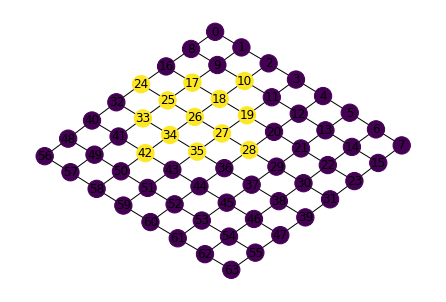

Graph with train/test split:


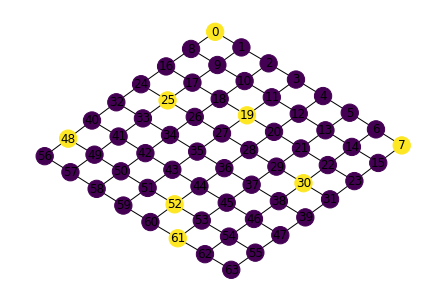

In [64]:
print("Graph with class labels:")
nx.draw_kamada_kawai(G,with_labels=True,node_color=get_att_array(G,'classlabel'))
plt.show()
print("Graph with train/test split:")
nx.draw_kamada_kawai(G,with_labels=True,node_color=get_att_array(G,'testnode'))

### Now training and evaluation: 



In [87]:
# Setting up the GNN model

hiddim=12
gnn=MPGNN(numnodes,hiddim)

# Defining optimizer and loss function
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01, weight_decay=5e-4)
loss=nn.CrossEntropyLoss()

# Initializing the model for training. This is not yet doing the actual training!
gnn.train() 

MPGNN(
  (layers): Sequential(
    (0): MPLayer()
    (1): ReLU()
    (2): MPLayer()
    (3): ReLU()
    (4): Linear(in_features=12, out_features=2, bias=True)
  )
)

Now comes the actual training. At the end we plot the curves of accuracies on training and test nodes, and visualize the predictions on the graph. Since we here have only a tiny dataset, we do not divide the data further into batches. Each 'epoch' of training takes all the labeled training nodes in one batch. 

In [84]:
def train(gnn, x, edge_index, y, train_mask, test_mask, epochs):
    losses=[]

    accuracies_train=[]
    accuracies_test=[]
    
    
    for epoch in range(epochs):
        t=0 # count of true predictions
        f=0 # count of false predictions
        epochloss=0
        
        optimizer.zero_grad()
    
        # forward propagation
        out = gnn(x,edge_index)

        # The following code is only to record the accuracies on train and test nodes
        # during the iterations. It is not part of the actual learning process
        pred = torch.argmax(out,1)   
        t_train=len(np.where(y[train_mask]==pred[train_mask])[0])
        f_train= len(y[train_mask])-t_train
        accuracies_train.append(t_train/len(y[train_mask]))
        
        t_test=len(np.where(y[test_mask]==pred[test_mask])[0])
        f_test= len(y[test_mask])-t_test
        accuracies_test.append(t_test/len(y[test_mask]))
        

        # Now back to the key learning operations: calculate loss and backpropagate
        l = loss(out[train_mask],y[train_mask])
        epochloss+=l.detach().item()
        l.backward()
        optimizer.step()
        
        losses.append(epochloss)

    print("final train accuracy: {}".format(accuracies_train[-1]))    
    print("final test accuracy: {}".format(accuracies_test[-1]))
    
    return losses, pred, accuracies_train, accuracies_test

final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final

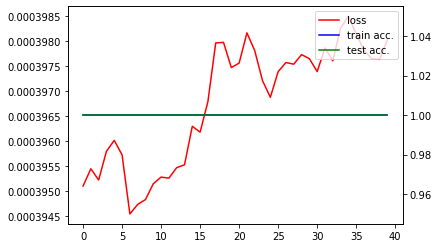

Predicted classes:


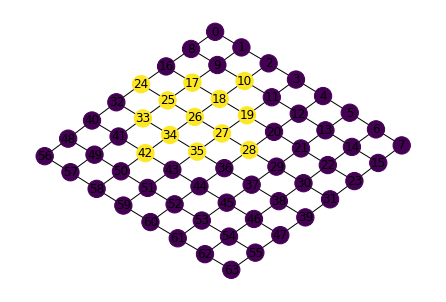

In [88]:
acc_exp = []
acc_exp_test = []
num_of_exps = 20
epochs = 40

gnn.init()
for exp in range(num_of_exps):
    losses, pred, accuracies_train, accuracies_test = train(gnn, x, edge_index, y, train_mask, test_mask, epochs)
    acc_exp.append(accuracies_train[-1])
    acc_exp_test.append(accuracies_test[-1])
    


fig,axes = plt.subplots(1,1)
rightax=axes.twinx()
axes.plot(losses,c='r',label='loss')
rightax.plot(accuracies_train,c='b',label='train acc.')
rightax.plot(accuracies_test,c='g',label='test acc.')
# Stuff for constructing a joint legend for curves associated with left and
# right y-axes
lines, labels = axes.get_legend_handles_labels()
linesr, labelsr = rightax.get_legend_handles_labels()
rightax.legend(lines + linesr, labels + labelsr)

plt.show()


# Adding the predicted class as another node attribute:
for i in range(numnodes):
    G.add_node(i,pred=pred[i])

print("Predicted classes:")
nx.draw_kamada_kawai(G,with_labels=True,node_color=get_att_array(G,'pred'))

In [89]:
print(f'Stats over {num_of_exps} experiments of {epochs} epochs:')
print(f'Average train accuracy: {np.mean(acc_exp)}')
print(f'Average test accuracy: {np.mean(acc_exp_test)}')

Stats over 20 experiments of 40 epochs:
Average train accuracy: 1.0
Average test accuracy: 1.0


## Task 1: 

Conduct experiments with the given model and graph: what train/test accuracies do you get on average when running the experiment multiple times? How does this change when you increase or decrease the number of training epochs?

#### Observations:
Stats over 20 experiments of 100 epochs:
- Average train accuracy: 1.0
- Average test accuracy: 0.94375

Stats over 20 experiments of 80 epochs:
- Average train accuracy: 1.0
- Average test accuracy: 1.0

Stats over 20 experiments of 60 epochs:
- Average train accuracy: 1.0
- Average test accuracy: 1.0

Stats over 20 experiments of 40 epochs:
- Average train accuracy: 1.0
- Average test accuracy: 0.9875

Stats over 20 experiments of 20 epochs:
- Average train accuracy: 0.9964285714285716
- Average test accuracy: 0.99375



What is the minimum value of hiddim for which the model can accurately represent the target classification? What happens in practice when you increase/decrease the hiddim value?    

#### Observation

Stats over 20 experiments of 40 epochs hddim 4:
- Average train accuracy: 0.9901785714285714
- Average test accuracy: 0.98125

Stats over 20 experiments of 40 epochs hddim 2:
- Average train accuracy: 0.9633928571428572
- Average test accuracy: 0.8875

Stats over 20 experiments of 40 epochs hddim 12:
- Average train accuracy: 1.0
- Average test accuracy: 1.0

Here we can see an increased hhdim is better.
    

## Task 2: 

Add to your training graph a color attribute as on slide 17. Train the model on this graph and evaluate

<ul>
    <li> on the test nodes of the training graph (as in Task 1)
    </li>
    <li> on nodes in new completely unlabeled graphs. For this, construct new graphs where the nodes have a yellow/blue color attribute. The new graphs can resemble the original training graph to a greater or lesser extent. E.g., they can again be regular rectangular grids, or they can have very different structures. Do the predictions on the new graphs match the "definition" of the class label that a node is red if it is at a distance at most 2 from a blue node?
    </li> 
    </ul>

        * We start by generating dataset with 2 blue nodes, with dist. <= 2 to the blue nodes we will color red, as from slide


        * First plot we show the blue nodes

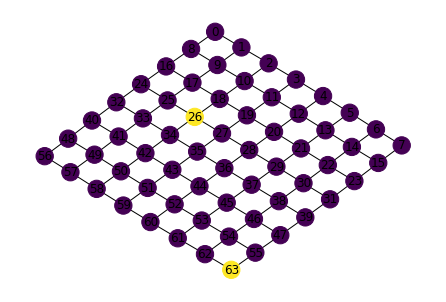

In [152]:
G2 = G.copy()
# add blue color to node 26, all nodes u with dist(u,26)<=2 will have y=1
blue_color = torch.zeros(numnodes,dtype=torch.int64)
red_color = torch.zeros(numnodes,dtype=torch.int64)

blue_color[[26,63]]=1
# reds around 26
red_color[[24,25,26,27,28,17,18,19,33,34,35,42,10]]=1
# reds around 63
red_color[[63,62,54,55,61,47]] = 1
for i in range (numnodes):
    G2.add_node(i,blue_color=blue_color[i])
    G2.add_node(i,red_color=red_color[i])

nx.draw_kamada_kawai(G2, with_labels=True,node_color=get_att_array(G2,'blue_color'))

        * Second lot we show the red nodes, which are <= 2 to the blue nodes 
        * we try make nicer plot, but color_map have some bug issue maybe

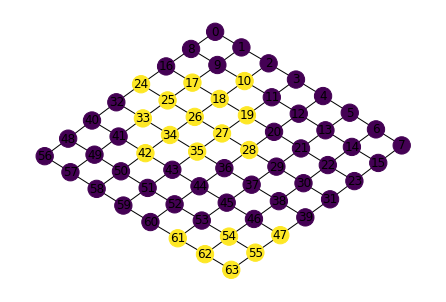

In [153]:
# plot red label nodes (within 2 of blue nodes)
nx.draw_kamada_kawai(G2, with_labels=True,node_color=get_att_array(G2,'red_color'))

        * Now we train the model on this coloring scheme, it must predict the red nodes as class label 1
        * We will again set x to use shallow one-hot encoding as embedding, this we expect will result in only transductive capabilities we expect
        * y will be red nodes with class=1
        * edge index again same, because we use same 8x8 grid graph
        * test_nodes we will make some "random" split, use same as above split
        * we use same a default architecture

In [ ]:
# shallow embedding, not functional embedding used
# node attributes: one-hot encoding of the identifiers is just the
# identity matrix constructed by torch.eye
x = torch.eye(numnodes)

# class label: we here manually label all nodes with distance <=2 to node '26' as belonging to class '1' 
y = red_color
    
# defining train/test nodes:
testnodes=(0,7,19,25,30,48,52,61) # a random selection of a set of test nodes

# Train and test nodes are defined in Pytorch Geometric by boolean "masking" vectors
train_mask=torch.ones(numnodes,dtype=torch.bool)
test_mask=torch.zeros(numnodes,dtype=torch.bool)

for i in range(numnodes):
    G.add_node(i,testnode=False)
for i in testnodes:
    train_mask[i]=False
    test_mask[i]=True
    G.add_node(i,testnode=True)

        * train the network

final train accuracy: 1.0
final test accuracy: 0.875
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
final test accuracy: 1.0
final train accuracy: 1.0
fin

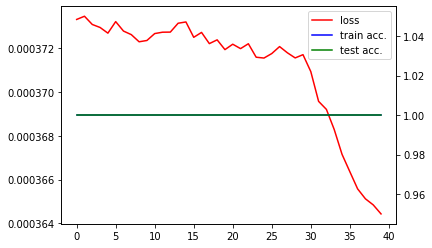

In [159]:
# Setting up the GNN model
hiddim=8
gnn=MPGNN(numnodes,hiddim)

# Defining optimizer and loss function
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01, weight_decay=5e-4)
loss=nn.CrossEntropyLoss()

# Initializing the model for training. This is not yet doing the actual training!
gnn.train() 
gnn.init()

acc_exp = []
acc_exp_test = []
num_of_exps = 20
epochs = 40

gnn.init()
for exp in range(num_of_exps):
    losses, pred, accuracies_train, accuracies_test = train(gnn, x, edge_index, y, train_mask, test_mask, epochs)
    acc_exp.append(accuracies_train[-1])
    acc_exp_test.append(accuracies_test[-1])
    

fig,axes = plt.subplots(1,1)
rightax=axes.twinx()
axes.plot(losses,c='r',label='loss')
rightax.plot(accuracies_train,c='b',label='train acc.')
rightax.plot(accuracies_test,c='g',label='test acc.')
# Stuff for constructing a joint legend for curves associated with left and
# right y-axes
lines, labels = axes.get_legend_handles_labels()
linesr, labelsr = rightax.get_legend_handles_labels()
rightax.legend(lines + linesr, labels + labelsr)

plt.show()

In [160]:
print(f'Stats over {num_of_exps} experiments of {epochs} epochs:')
print(f'Average train accuracy: {np.mean(acc_exp)}')
print(f'Average test accuracy: {np.mean(acc_exp_test)}')

Stats over 20 experiments of 40 epochs:
Average train accuracy: 1.0
Average test accuracy: 0.99375


        * It seems still simple task to learn which nodes are <= blue, but of course here
        the network can just learn to set weights for all red nodex to 1, and the other to 0, and it will get perfect results
        so simple task it seems
        * but inherently inductive because shallow embedding

        * To show that the model is inherently transductive we will generate new dataset, where we move the two blue nodes,
        and respectively the red nodes also

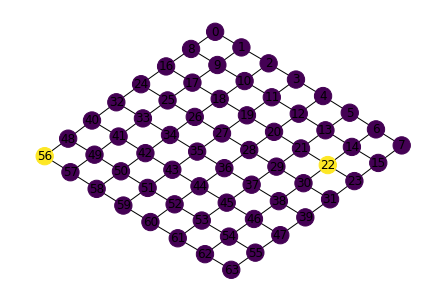

In [169]:
G2 = G.copy()
# add blue color to node 26, all nodes u with dist(u,26)<=2 will have y=1
blue_color = torch.zeros(numnodes,dtype=torch.int64)
red_color2 = torch.zeros(numnodes,dtype=torch.int64)

blue_color[[22,56]]=1
# reds around 22
red_color2[[56,48,57,58,49,40]]=1
# reds around 63
red_color2[[22,29,21,13,14,15,23,31,38,20,6,30]] = 1
for i in range (numnodes):
    G2.add_node(i,blue_color=blue_color[i])
    G2.add_node(i,red_color=red_color2[i])

nx.draw_kamada_kawai(G2, with_labels=True,node_color=get_att_array(G2,'blue_color'))

        * Second plot we show the red nodes, which are <= 2 to the blue nodes 
        * we try make nicer plot, but color_map have some bug issue maybe

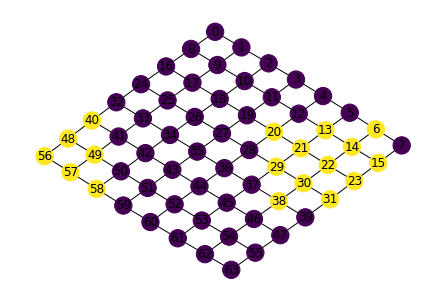

In [172]:
# plot red label nodes (within 2 of blue nodes)
nx.draw_kamada_kawai(G2, with_labels=True,node_color=get_att_array(G2,'red_color'))

        * Now we only predict on new dataset, we expect bad results
        * we use full graph to evaluate on

In [178]:
# still same 8x8 grid so x is same
# edge index also same, we keep graph structure
# set to eval mode
gnn.eval()
# forward propagation
out = gnn(x,edge_index)

# The following code is only to record the accuracies on train and test nodes
# during the iterations. It is not part of the actual learning process
pred = torch.argmax(out,1)   
trues=len(np.where(red_color2==pred)[0])
false= len(y)-trues
acc =trues/len(y)
print(f'Corrects {trues}/{trues+false} | Acc. on full dataset: {acc}.2f')

Corrects 33/64 | Acc. on full dataset: 0.515625.2f


        * As expected not too good, because shallow embeddings